In [115]:
import pandas as pd
import numpy as np
import seaborn as sns
import acessos as ac
import os 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
text_file = open(os.path.abspath('../Elasticidade CR - Simulações/sql/jan-mar-23.sql'), "r")
query = text_file.read()
text_file.close()
df = ac.df_athena_q('flavia-costa', query)

In [3]:
len(df)

172938

In [4]:
df.head()

,cpf,dt_mes_true,periodo_antes_inicio,periodo_antes_fim,periodo_depois_inicio,periodo_depois_fim,periodo_depois30_fim,qt_compra_antes_90d,dt_last_use_credit,vl_current_limit,...,ds_city_size,vl_compra_antes_90d,dt_first_use_credit,vl_renda_declarada,dt_criacao_conta,dias_uso_app,vl_compra_depois_30d,qt_compras_depois_30d,vl_compra_depois_60d,qt_compras_depois_60d
0,05374519190,2023-01-01,2022-10-02,2022-12-31,2023-02-01,2023-04-01,2023-03-01,2,2022-12-21,6800.0,...,None,14.16,2018-09-29 12:35:01,950.0,201808,0,1393.82,16,4463.66,17
1,15800358761,2023-01-01,2022-10-02,2022-12-31,2023-02-01,2023-04-01,2023-03-01,3,2022-12-28,600.0,...,medio,354.09,2022-11-28 16:56:30,3000.0,202211,12,325.00,1,567.50,2
2,70599393181,2023-01-01,2022-10-02,2022-12-31,2023-02-01,2023-04-01,2023-03-01,77,2022-12-30,17700.0,...,grande,4754.49,2018-11-17 17:11:52,0.0,201810,0,276.84,15,561.96,43
3,12226183469,2023-03-01,2022-11-30,2023-02-28,2023-04-01,2023-06-01,2023-05-01,2,2023-02-13,550.0,...,pequeno,355.18,2022-11-26 18:59:31,2000.0,202211,7,NaN,0,156.93,1
4,05276066426,2023-01-01,2022-10-02,2022-12-31,2023-02-01,2023-04-01,2023-03-01,10,2022-12-30,500.0,...,pequeno,551.16,2022-11-12 11:28:46,3500.0,202211,31,323.15,6,1128.50,15


In [5]:
df.columns

Index(['cpf', 'dt_mes_true', 'periodo_antes_inicio', 'periodo_antes_fim',
       'periodo_depois_inicio', 'periodo_depois_fim', 'periodo_depois30_fim',
       'qt_compra_antes_90d', 'dt_last_use_credit', 'vl_current_limit',
       'flag_problema', 'nr_tpr', 'nr_tma', 'nr_tmat', 'usou_chat',
       'hierarquia_1', 'ds_gender', 'ds_state_abbreviation', 'dt_birth',
       'ds_schooling', 'ds_marital_status', 'dt_opening_account',
       'ds_city_size', 'vl_compra_antes_90d', 'dt_first_use_credit',
       'vl_renda_declarada', 'dt_criacao_conta', 'dias_uso_app',
       'vl_compra_depois_30d', 'qt_compras_depois_30d', 'vl_compra_depois_60d',
       'qt_compras_depois_60d'],
      dtype='object')

In [6]:
df.dt_mes_true.value_counts()

2023-01-01    61632
2023-02-01    56571
2023-03-01    54735
Name: dt_mes_true, dtype: int64

Criação de variáveis

In [7]:
df['cc_time'] = (pd.Timestamp('now') - df['dt_opening_account'])/ np.timedelta64(1, 'D')
df['dt_first_use_credit'] = pd.to_datetime(df['dt_first_use_credit'], format='%Y-%m-%d')
df['dias_ativacao'] = (pd.Timestamp('now') - df['dt_first_use_credit'])/ np.timedelta64(1, 'D')
df['vl_compra_antes_90d_log'] = np.log(df.vl_compra_antes_90d) #Ajuste da variável


Função de normalização

In [8]:
def normalizando(df,columns):
    df[columns] = (df[columns]-df[columns].min())/(df[columns].max()-df[columns].min())
    return df[columns]

In [9]:
df_n = pd.DataFrame()

df_n['cc_time'] = normalizando(df, ['cc_time'])
df_n['vl_current_limit'] = normalizando(df, ['vl_current_limit'])
df_n['dias_uso_app'] = normalizando(df, ['dias_uso_app'])
df_n['vl_renda_declarada'] = normalizando(df, ['vl_renda_declarada'])
df_n['dias_ativacao'] = normalizando(df, ['dias_ativacao'])
df_n['qt_compra_antes_90d'] = normalizando(df, ['qt_compra_antes_90d'])


In [10]:
df_n.head()

,cc_time,vl_current_limit,dias_uso_app,vl_renda_declarada,dias_ativacao,qt_compra_antes_90d
0,0.787456,0.075556,0.000000,0.000010,0.738226,0.001340
1,0.097952,0.006667,0.131868,0.000033,0.080234,0.002681
2,0.762535,0.196667,0.000000,0.000000,0.716947,0.101877
3,0.091026,0.006111,0.076923,0.000022,0.081062,0.001340
4,0.095225,0.005556,0.340659,0.000038,0.087253,0.012064


In [11]:
#Parametros modelo
#c_intercepto = -2.2261
#c_usou_chat = -0.1428
#c_flag_problema = 0.3520

Atribuindo clientes sem atendimento

In [12]:
queda_cr = 0.1
df['aleat'] = np.random.random((len(df),1))
df['usou_chat_sim'] = np.where(df.aleat <= (1 - queda_cr), 1, 0)
df['flag_problema_sim'] = np.where(df.usou_chat_sim == 0, 0, df.flag_problema )
df['teve_compra_depois'] = np.where(df.vl_compra_depois_60d > 0 , 1, 0)

In [13]:
df['rawPrediction'] = -2.2261  + (df.usou_chat_sim * -0.1428) + (df.flag_problema_sim * 0.3520) + ( df.vl_compra_antes_90d_log * 0.5312) + (df_n.cc_time * -0.8862)
+ (df_n.vl_current_limit * -0.2775) + (df_n.dias_uso_app * 0.7885) + (df_n.vl_renda_declarada * 3.7359) + (df_n.dias_ativacao * 0.5817) + (df_n.qt_compra_antes_90d * 0.6022)

df['score_compra_depois']  =  1/(1 + np.exp(-1 * df.rawPrediction))

In [14]:
df.usou_chat_sim.value_counts(normalize=True)

1    0.899987
0    0.100013
Name: usou_chat_sim, dtype: float64

In [43]:
df.groupby('usou_chat_sim')["score_compra_depois"].mean()

usou_chat_sim
0    0.749032
1    0.745048
Name: score_compra_depois, dtype: float64

In [154]:
df.groupby('usou_chat_sim')["score_compra_depois"].median()

usou_chat_sim
0    0.782009
1    0.776670
Name: score_compra_depois, dtype: float64

In [16]:
df.teve_compra_depois.value_counts()

1    139872
0     33066
Name: teve_compra_depois, dtype: int64

In [17]:
df[df.teve_compra_depois == 0]['usou_chat_sim'].value_counts()

1    29661
0     3405
Name: usou_chat_sim, dtype: int64

In [18]:
df.vl_compra_antes_90d.mean()

2083.348703234685

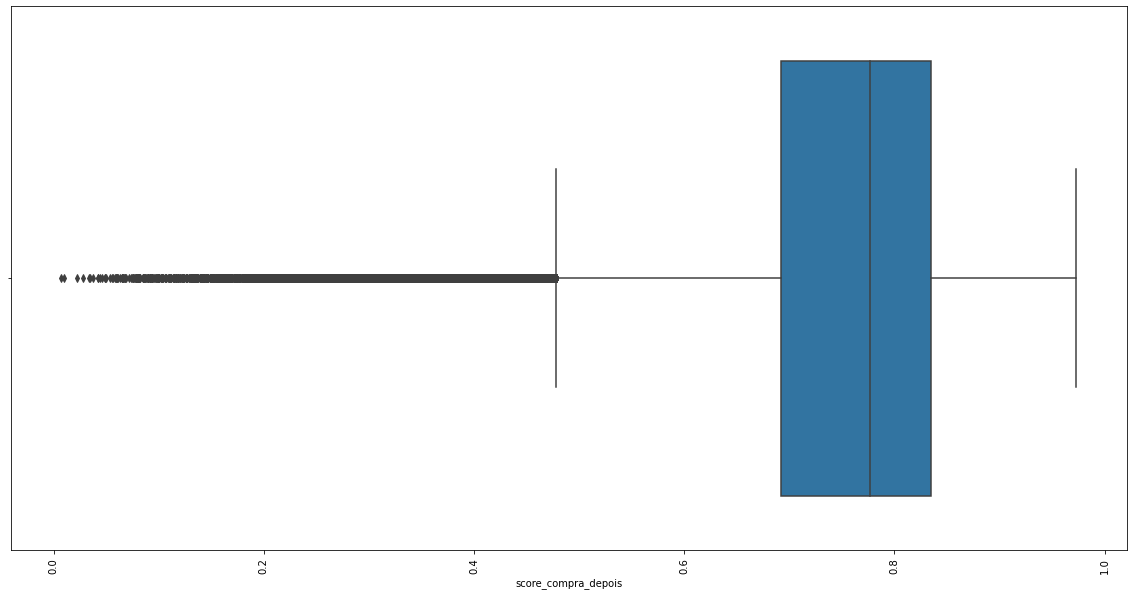

In [157]:
plt.figure(figsize = (20,10))
sns.boxplot(data = df[df['usou_chat_sim'] == 1], x = 'score_compra_depois')
plt.xticks(rotation=90)
plt.show()

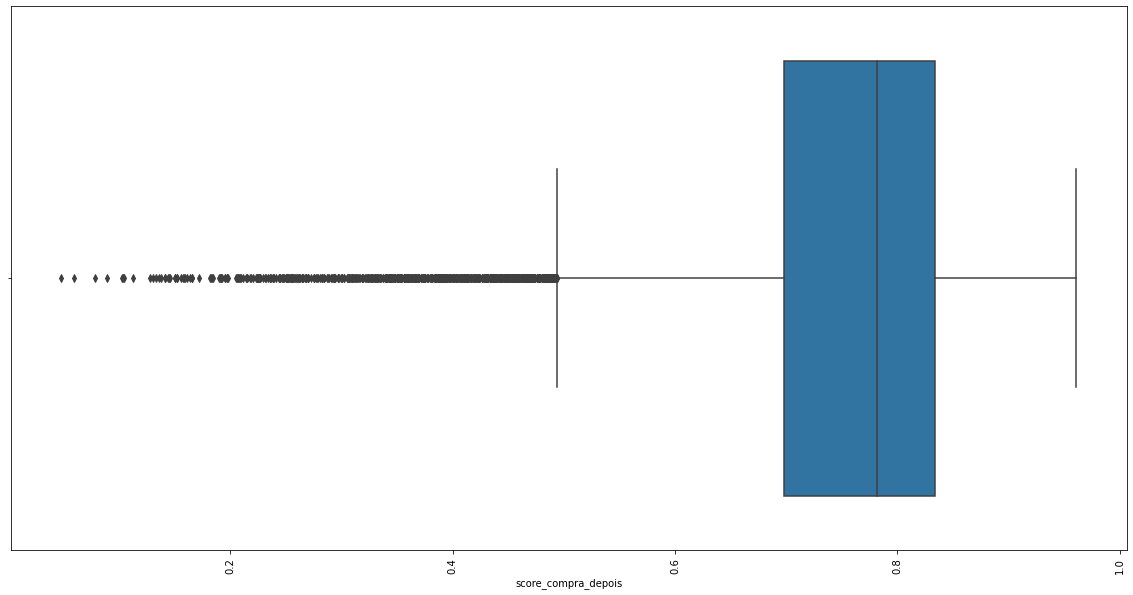

In [158]:
plt.figure(figsize = (20,10))
sns.boxplot(data = df[df['usou_chat_sim'] == 0], x = 'score_compra_depois')
plt.xticks(rotation=90)
plt.show()

Aferindo o melhor threshold através da curva cumulativa e KS

In [64]:
df['fx_score'] = np.round(df['score_compra_depois'],1)
df.groupby('fx_score')["teve_compra_depois"].mean()

fx_score
0.0    0.466667
0.1    0.464912
0.2    0.521898
0.3    0.502448
0.4    0.584946
0.5    0.653193
0.6    0.691666
0.7    0.771911
0.8    0.858339
0.9    0.892891
1.0    0.864865
Name: teve_compra_depois, dtype: float64

In [163]:
df['alto_score'] = np.where(df.fx_score > 0.2, 1, 0)

df.groupby('alto_score')["usou_chat_sim"].mean()

alto_score
0    0.911071
1    0.899916
Name: usou_chat_sim, dtype: float64

In [65]:
agg_df_compra_sim = df[df['teve_compra_depois'] == 1][['fx_score', 'cpf']].groupby('fx_score').count()
agg_df_compra_nao = df[df['teve_compra_depois'] == 0][['fx_score', 'cpf']].groupby('fx_score').count()

In [83]:
agg_df_compra = agg_df_compra_sim.join(agg_df_compra_nao, lsuffix='nao', rsuffix='sim')
agg_df_compra = agg_df_compra.reset_index()
agg_df_compra['cumperc_nao'] = agg_df_compra['cpfnao'].cumsum()/agg_df_compra['cpfnao'].sum()*100
agg_df_compra['cumperc_sim'] = agg_df_compra['cpfsim'].cumsum()/agg_df_compra['cpfsim'].sum()*100

agg_df_compra['dif'] = agg_df_compra['cumperc_nao'] - agg_df_compra['cumperc_sim']
agg_df_compra['dif_abs'] = np.abs(agg_df_compra['dif'])


In [84]:
agg_df_compra

,fx_score,cpfnao,cpfsim,cumperc_nao,cumperc_sim,dif,dif_abs
0,0.0,7,8,0.005006,0.024197,-0.019191,0.019191
1,0.1,106,122,0.080807,0.393201,-0.312393,0.312393
2,0.2,429,393,0.387589,1.581876,-1.194288,1.194288
3,0.3,821,813,0.974692,4.040893,-3.066201,3.066201
4,0.4,1935,1373,2.358426,8.193697,-5.835270,5.835270
5,0.5,5850,3106,6.541809,17.588168,-11.046359,11.046359
6,0.6,11113,4954,14.488805,32.572137,-18.083332,18.083332
7,0.7,29284,8653,35.430030,58.744178,-23.314147,23.314147
8,0.8,62245,10273,79.941933,89.816103,-9.874170,9.874170
9,0.9,27985,3357,99.954233,99.969754,-0.015521,0.015521


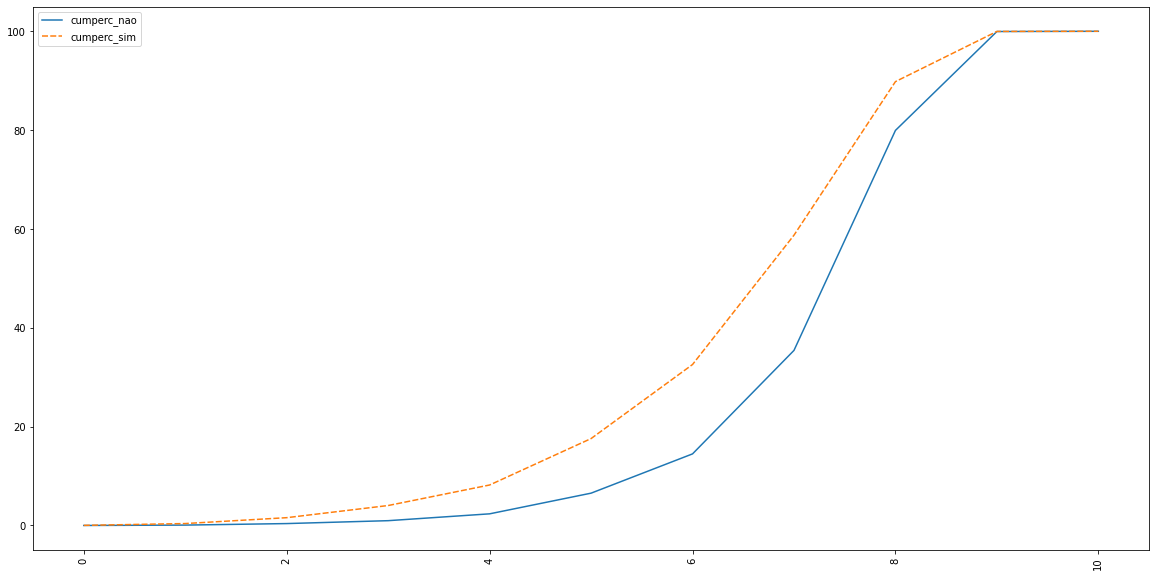

In [88]:
plt.figure(figsize = (20,10))
sns.lineplot(data = agg_df_compra[['cumperc_nao', 'cumperc_sim']])
plt.xticks(rotation=90)
plt.show()

In [112]:
#quando a diferença nas distribuições ficar acima de 10%
threshould_conservador = agg_df_compra.query('dif_abs > 10')['fx_score'].min()

In [113]:
df['compra_depois_propensao']  = np.where(df['score_compra_depois'] > threshould_conservador, 1,0)
df['compra_depois_propensao'].value_counts()

1    163005
0      9933
Name: compra_depois_propensao, dtype: int64

In [153]:
len(df[df['usou_chat_sim'] == 0]) 

17296

In [150]:
len(df[df['teve_compra_depois'] == 0]) 


33066

In [152]:
len(df.query('teve_compra_depois == 0 & usou_chat_sim == 0'))

3405

In [164]:
len(df.query('teve_compra_depois == 0 & usou_chat_sim == 0 & compra_depois_propensao == 0'))

372

In [165]:
len(df.query('teve_compra_depois == 0 & usou_chat_sim == 0 & compra_depois_propensao == 1'))

3033

In [148]:
#vou inputar spending para o cliente que teve churn de fato, que foi sorteado para não ter atendimento na simulação e com baixo score de compra depois
df['flag_atribui_spending'] = np.where((df['compra_depois_propensao'] == 1) & (df['teve_compra_depois'] == 0) & (df.usou_chat_sim == 0),1,0)
df['flag_atribui_spending'].value_counts()

0    169905
1      3033
Name: flag_atribui_spending, dtype: int64

In [118]:
df_comprou = df.query('teve_compra_depois == 1')

formula_text = ("""
    vl_compra_depois_60d ~ 
    C(periodo_depois30_fim) + 
       qt_compra_antes_90d +  vl_current_limit + 
       C(ds_gender) + C(ds_state_abbreviation) + C(ds_schooling) + 
       C(ds_marital_status) + cc_time + dias_ativacao + 
       C(ds_city_size) + vl_compra_antes_90d + vl_renda_declarada  + dias_uso_app
    """)

model = ols(formula = formula_text, data = df_comprou).fit()
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     vl_compra_depois_60d   R-squared:                       0.498
Model:                              OLS   Adj. R-squared:                  0.498
Method:                   Least Squares   F-statistic:                     1650.
Date:                  Mon, 19 Jun 2023   Prob (F-statistic):               0.00
Time:                          21:31:17   Log-Likelihood:            -8.0006e+05
No. Observations:                 91480   AIC:                         1.600e+06
Df Residuals:                     91424   BIC:                         1.601e+06
Df Model:                            55                                         
Covariance Type:              nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

In [119]:
df_nao_comprou = df.query('flag_atribui_spending == 1')

In [125]:
#lidar com NAS
df_nao_comprou.head()

,cpf,dt_mes_true,periodo_antes_inicio,periodo_antes_fim,periodo_depois_inicio,periodo_depois_fim,periodo_depois30_fim,qt_compra_antes_90d,dt_last_use_credit,vl_current_limit,...,aleat,usou_chat_sim,flag_problema_sim,teve_compra_depois,rawPrediction,score_compra_depois,fx_score,compra_depois_propensao,flag_atribui_spending,fx_score2
123,18396203741,2023-01-01,2022-10-02,2022-12-31,2023-02-01,2023-04-01,2023-03-01,0.000000,2022-10-20,0.024267,...,0.911277,0,0,0,-0.643411,0.344476,0.3,0,1,0.3
227,17202936607,2023-01-01,2022-10-02,2022-12-31,2023-02-01,2023-04-01,2023-03-01,0.006702,2022-10-16,0.001111,...,0.925460,0,0,0,-0.042198,0.489452,0.5,0,1,0.5
631,05208266636,2023-02-01,2022-11-02,2023-01-31,2023-03-01,2023-05-01,2023-04-01,0.001340,2023-01-13,0.011111,...,0.957580,0,0,0,-0.312669,0.422463,0.4,0,1,0.4
1018,07768157338,2023-02-01,2022-11-02,2023-01-31,2023-03-01,2023-05-01,2023-04-01,0.000000,2022-12-19,0.013333,...,0.949901,0,0,0,-1.735896,0.149835,0.1,0,1,0.1
1165,97997188053,2023-01-01,2022-10-02,2022-12-31,2023-02-01,2023-04-01,2023-03-01,0.000000,2022-12-23,0.026667,...,0.917868,0,0,0,-0.886450,0.291843,0.3,0,1,0.3


In [127]:
for column in df_nao_comprou.columns:
  if df_nao_comprou[column].dtype == 'object':
    df_nao_comprou[column].fillna(df_nao_comprou[column].mode()[0], inplace = True)
  elif df_nao_comprou[column].dtype != 'object':
    df_nao_comprou[column].fillna(df_nao_comprou[column].median(), inplace = True)

/tmp/ipykernel_85664/2382570217.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nao_comprou[column].fillna(df_nao_comprou[column].mode()[0], inplace = True)
/tmp/ipykernel_85664/2382570217.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nao_comprou[column].fillna(df_nao_comprou[column].mode()[0], inplace = True)
/tmp/ipykernel_85664/2382570217.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nao_comprou[column].fill

In [128]:
prediction = model.predict(df_nao_comprou)

In [122]:
len(prediction)

372

In [145]:
prediction.sum()

218997.99473159522

In [143]:
df_nao_comprou['valor incremental'] = prediction

resultado_sim = df_nao_comprou[['hierarquia_1', 'valor incremental', 'dt_mes_true']].groupby(['hierarquia_1', 'dt_mes_true']).sum()
resultado_sim = resultado_sim.reset_index()


/tmp/ipykernel_85664/2520303333.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nao_comprou['valor incremental'] = prediction


In [144]:
resultado_sim

,hierarquia_1,dt_mes_true,valor incremental
0,Atendimento,2023-03-01,895.098652
1,Cartão,2023-01-01,35835.372399
2,Cartão,2023-02-01,25106.557788
3,Cartão,2023-03-01,23774.622652
4,Conta,2023-01-01,1174.110595
5,Conta,2023-02-01,3766.716992
6,Conta,2023-03-01,3894.413840
7,Crédito e Cobrança,2023-01-01,27446.697629
8,Crédito e Cobrança,2023-02-01,30422.547045
9,Crédito e Cobrança,2023-03-01,40829.437418


In [139]:
resultado_sim['valor incremental']

,hierarquia_1,valor incremental
0,Atendimento,895.098652
1,Cartão,84716.552839
2,Conta,8835.241427
3,Crédito e Cobrança,98698.682091
4,Fraude,23164.507417
5,Marketing,2206.313101
6,Tecnologia,481.599205
